In [1]:
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_data(file: str) -> pd.DataFrame:
    data = []
    with open(f"data\\{file}", "r") as file:
        for idx, line in enumerate(file.readlines()):
            # Skip Metadata lines
            if idx in [0, 1, 2, 3, 4, 6]:
                continue

            data.append(line)

    return pd.read_csv(StringIO("".join(data))).rename(
        columns={
            "Load (lbf)": "Load (lbs)",
        }
    )

In [3]:
brush_tests = [
    "1",
    "2",
    "3",
    "4",
    "5",
    "5a",
    "6",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
]

dataframes = {}
for brush in brush_tests:
    dataframes[brush] = get_data(f"Ankenman brushes_{brush}.txt")

In [4]:
df = (
    pd.concat(
        [df.reset_index(drop=True) for df in dataframes.values()],
        keys=dataframes.keys(),
        names=["Brush"],
    )
    .reset_index()
    .drop(columns=["level_1"])
)
df_load_max = df.groupby("Brush").max()[["Load (lbs)"]]
df_load_max = df_load_max.reindex(brush_tests)

In [5]:
df_load_max = df_load_max.drop([])
df_load_max

,Load (lbs)
Brush,
1,216
2,107
3,152
4,236
5,199
5a,199
6,127
7,208
8,232


In [6]:
n = len(df_load_max)
sample_mean = df_load_max["Load (lbs)"].mean()
sample_median = df_load_max["Load (lbs)"].median()
sample_stddev = df_load_max["Load (lbs)"].std()

In [7]:
def E1(x: np.ndarray) -> np.float64:
    return np.mean(x) - 1.28 * np.std(x, ddof=1)

In [8]:
def get_E1_confidence_interval(sample_size: int) -> np.ndarray:
    data = np.random.normal(
        loc=sample_mean, scale=sample_stddev, size=(10_000, sample_size)
    )

    E1_values = np.apply_along_axis(E1, 1, data)

    E1_mean = E1_values.mean()
    E1_stddev = E1_values.std(ddof=1)

    return np.array([E1_mean - 2 * E1_stddev, E1_mean + 2 * E1_stddev])

In [9]:
E1_intervals = []
for sample_size in range(5, 100, 5):
    E1_intervals.append(get_E1_confidence_interval(sample_size))

E1_intervals = np.array(E1_intervals)
E1_intervals

array([[ 75.96842725, 185.39210425],
       [ 90.61485349, 167.61759022],
       [ 97.47595603, 159.48541512],
       [100.88512033, 155.28922586],
       [103.63619783, 152.15274592],
       [105.88808381, 150.05696839],
       [107.55926023, 148.18091937],
       [108.58178073, 146.75597442],
       [109.46851774, 145.661394  ],
       [110.66696864, 144.84630953],
       [111.4268382 , 143.78649373],
       [112.27538455, 142.84562053],
       [112.61573521, 142.44472357],
       [113.30745304, 141.91728202],
       [113.60878918, 141.62361696],
       [114.03305276, 141.07815685],
       [114.59462751, 140.58849083],
       [114.78182093, 140.22052019],
       [115.3716295 , 139.91190686]])

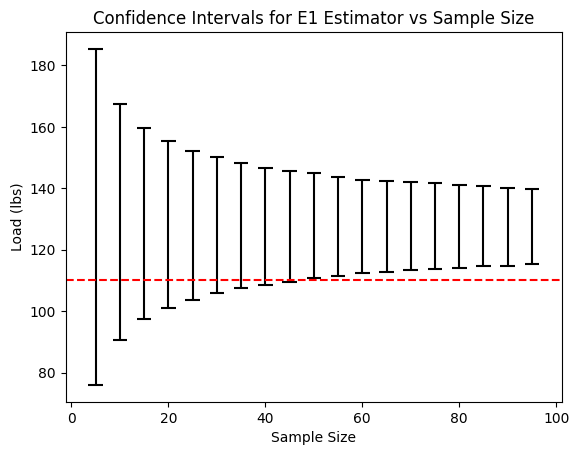

In [10]:
for idx, sample_size in enumerate(range(5, 100, 5)):
    interval = E1_intervals[idx]
    plt.vlines(x=sample_size, ymin=interval[0], ymax=interval[1], color="black")
    plt.hlines(
        y=interval[0], xmin=sample_size - 1.5, xmax=sample_size + 1.5, color="black"
    )
    plt.hlines(
        y=interval[1], xmin=sample_size - 1.5, xmax=sample_size + 1.5, color="black"
    )

plt.axhline(y=110, color="red", linestyle="--", label="110 lbs Threshold")

plt.title("Confidence Intervals for E1 Estimator vs Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Load (lbs)")

plt.show()

### With about 50 Samples we get a Confidence Interval that would be completely over 100 lbs
### -> Destroy about 36 more brushes seems feasible (Maybe include Fail-Ratio with CI with Proportion)